In [1]:
import rishi_utils as ru
import importlib
importlib.reload(ru)
from rdkit import Chem
import fall20_mse_8803 as retro
importlib.reload(retro)
from rdkit.Chem import AllChem
import pandas as pd

***I need to fix sg_possible to only fragment bonds which appear in the main chain***

# Incorporate volume into FRP

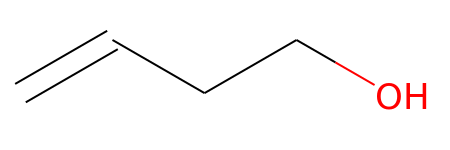

In [9]:
m=Chem.MolFromSmiles('C=C(CCO)')
m

In [22]:
m2 = Chem.MolFromSmiles('*C=C*')
lp = ru.LinearPol(m2)
lp._HasSubstructMatch('C')

True

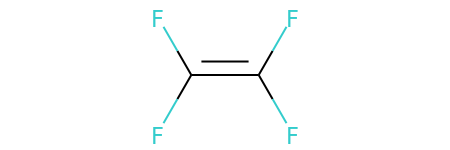

In [19]:
m3 = Chem.MolFromSmiles('C(F)(F)=C(F)(F)')
m3

In [22]:
Chem.rdMolDescriptors.CalcTPSA(m),Chem.rdMolDescriptors.CalcTPSA(m2),Chem.rdMolDescriptors.CalcTPSA(m3,force=True,includeSandP=True)

(20.23, 0.0, 0.0)

In [29]:
m4 = Chem.MolFromSmiles('C(F)(F)')
Chem.AllChem.EmbedMolecule(m4)
Chem.AllChem.ComputeMolVolume(m4)

35.66400000000001

In [13]:
m4 = Chem.MolFromSmiles('CC')
Chem.AllChem.EmbedMolecule(m4)
Chem.AllChem.ComputeMolVolume(m4)

33.44800000000001

In [2]:
m4 = Chem.MolFromSmiles('C')
Chem.AllChem.EmbedMolecule(m4)
Chem.AllChem.ComputeMolVolume(m4)

20.424000000000007

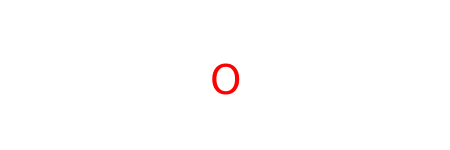

In [3]:
Chem.MolFromSmarts('[OH]')

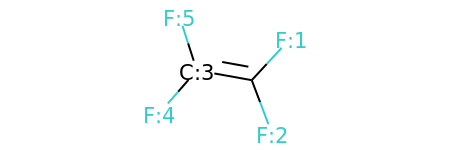

In [30]:
ru.mol_with_atom_index(m3)

In [36]:
b=m3.GetBondBetweenAtoms(0,3)

In [34]:
em = Chem.EditableMol(m3)

In [37]:
em.RemoveBond(b.GetBeginAtomIdx(), b.GetEndAtomIdx())

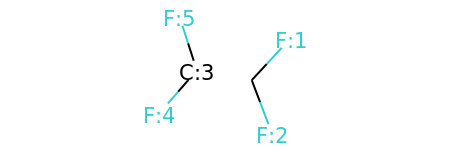

In [38]:
m = em.GetMol()
m

In [39]:
out = Chem.GetMolFrags(m, asMols=True)
out

(<rdkit.Chem.rdchem.Mol at 0x7fa5f34d6570>,
 <rdkit.Chem.rdchem.Mol at 0x7fa5f34d65d0>)

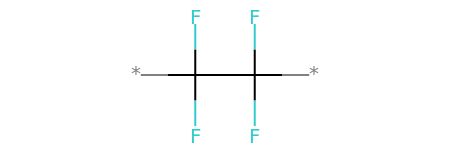

In [52]:
m4 = Chem.MolFromSmiles('*C(F)(F)C(F)(F)*')
m4

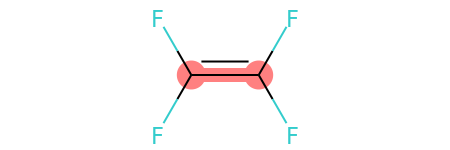

In [53]:
retro.frp_depolymerize(m4) #should pass

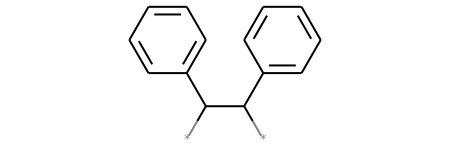

In [58]:
m5 = Chem.MolFromSmiles('*C(c1ccccc1)C(*)c2ccccc2')
m5

In [59]:
retro.frp_depolymerize(m5) #should fail

83.91200000000002


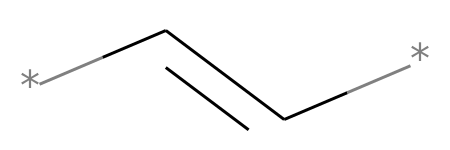

In [61]:
m6 = Chem.MolFromSmiles('*C=C*')
m6

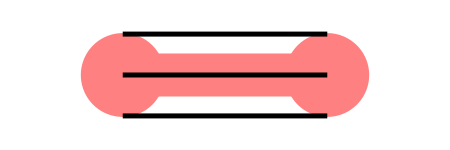

In [67]:
retro.frp_depolymerize(m6) #should work

# Allow for frp of monomers with triple bond

In [ ]:
m = Chem.MolFromSmiles('*C=C*')
m

In [ ]:
retro.frp_depolymerize(m)

In [ ]:
m2 = Chem.MolFromSmiles('*CC*')
m2

In [ ]:
retro.frp_depolymerize(m2)

# Cyclopolymerization scratch

In [ ]:
m = Chem.MolFromSmiles('*C=C1C=C(*)CCC1')
m

In [ ]:
# check that non-aromatic ring is there
ri = m.GetRingInfo()

In [ ]:
non_aromatic_rings = []
for ind,ring in enumerate(ri.BondRings()):
    for bond_ind in ring:
        if m.GetBonds()[bond_ind].GetBondType() != Chem.rdchem.BondType.AROMATIC:
            non_aromatic_rings.append(ind)
non_aromatic_rings = set(non_aromatic_rings)

In [ ]:
non_aromatic_rings

In [ ]:
ru.mol_with_atom_index(m)

In [ ]:
# check that connection point is on ring
lp = ru.LinearPol(m)
non_aromatic_ring_atoms = []
ring_connection_atom_ind = False
ring_connection_ring_ind = False
for ind,ring in enumerate(ri.AtomRings()):
    if ind in non_aromatic_rings:
        for atom_ind in ring:
            if atom_ind in lp.connector_inds:
                ring_connection_atom_ind  = atom_ind
                ring_connection_ring_ind = ind
                
ring_connection_atom_ind,ring_connection_ring_ind

In [ ]:
#cycle through all ring bonds of ring_connection_ring_ind
monomers = []
patt1 = Chem.MolFromSmiles('*CC*')
patt2 = Chem.MolFromSmiles('*C=C*')
for bond_ind in ri.BondRings()[ring_connection_ring_ind]:
    bond = m.GetBondWithIdx(bond_ind)
    if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
        em = Chem.EditableMol(m)
        atoms = (bond.GetBeginAtomIdx(),bond.GetEndAtomIdx())
        em.RemoveBond(atoms[0],atoms[1])
        ind1=em.AddAtom(Chem.AtomFromSmiles('*'))
        ind2=em.AddAtom(Chem.AtomFromSmiles('*'))
        em.AddBond(atoms[0],ind1,Chem.rdchem.BondType.SINGLE)
        em.AddBond(atoms[1],ind2,Chem.rdchem.BondType.SINGLE)
        new_mol = em.GetMol()
        n_matches = len(new_mol.GetSubstructMatches(patt1)) + len(new_mol.GetSubstructMatches(patt2))
        if n_matches == 2:
            monomers.append(new_mol)

In [ ]:
a=monomers[0]
a = ru.mol_with_atom_index(a)

In [ ]:
a

In [ ]:
a.GetSubstructMatches(Chem.MolFromSmarts('[#0]C=C[#0]'))

In [ ]:
rxn = AllChem.ReactionFromSmarts('[#0]C([*:1])=C[#0]>>[*:1]C#C')

In [ ]:
ps = rxn.RunReactants((a,))

In [ ]:
ps[0][0]

In [ ]:
rxn.RunReactants((ps[0][0],))[0][0]

# test cyclodepolymerize

In [ ]:
m = Chem.MolFromSmiles('*C=C1C=C(*)CCC1')
m

In [ ]:
ru.mol_with_atom_index(m)

In [ ]:
out=retro.cyclodepolymerize(m)

In [ ]:
out[0]

In [ ]:
m = Chem.MolFromSmiles('*CC1C=C(*)CCC1')
m

In [ ]:
out=retro.cyclodepolymerize(m)[0]
out

In [ ]:
m = Chem.MolFromSmiles('*C=C1CC(*)CCC1')
m

In [ ]:
out=retro.cyclodepolymerize(m)[0]
out

# Test frp_possible without steric consideration

In [ ]:
m = Chem.MolFromSmiles('*CC(*)c1ccccc1')
m

In [ ]:
em = Chem.EditableMol(m)

In [ ]:
em.AddAtom(Chem.AtomFromSmiles('C'))

In [ ]:
m2 = Chem.MolFromSmiles('C=C')
m2

In [ ]:
patt = Chem.MolFromSmiles('*CC*')

In [ ]:
frp_possible(m) #should be True

In [ ]:
frp_possible(m2) #should be False

In [ ]:
m3 = Chem.MolFromSmiles('[*]C1Nc2ccc(C)cc2C1C1NCC2C([*])C(C)CC21')
frp_possible(m3) #should be False

In [ ]:
m4 = Chem.MolFromSmiles('*CC(*)c1cccc(C=C)c1')
frp_possible(m4) #should be False

# Test frp_depolymerize with side chain bonds

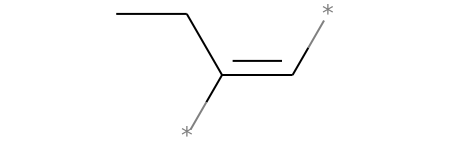

In [57]:
mol = Chem.MolFromSmiles('*C=C(CC)*')
mol

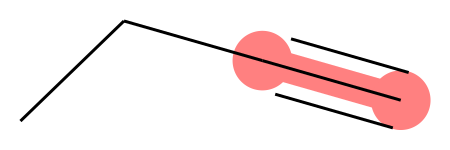

In [58]:
retro.frp_depolymerize(mol)

In [22]:
self = ru.LinearPol(mol)

In [28]:
main_chain_patt1 = Chem.MolFromSmiles('*CC*')
main_chain_patt2 = Chem.MolFromSmiles('*C=C*')

side_chain_patt1 = Chem.MolFromSmiles('C=C')
side_chain_patt2 = Chem.MolFromSmiles('C#C')
side_chain_patt3 = Chem.MolFromSmarts('[OH]')
sc_mol = ru.LinearPol(mol).SideChainMol()
mc_match1 = mol.HasSubstructMatch(main_chain_patt1)
mc_match2 = mol.HasSubstructMatch(main_chain_patt2)
sc_matches = sc_mol.HasSubstructMatch(side_chain_patt1) or sc_mol.HasSubstructMatch(side_chain_patt2) or sc_mol.HasSubstructMatch(side_chain_patt3)

In [29]:
sc_matches, mc_match1, mc_match2

(False, True, False)

# Test frp_possible with steric consideration

In [ ]:
m = Chem.MolFromSmiles('*CC(*)c1ccccc1')
m

In [ ]:
retro.frp_possible(m) #should be true

In [ ]:
m2 = Chem.MolFromSmiles('*C(c1ccccc1)C(*)c2ccccc2') #polystilbene
m2

In [ ]:
retro.frp_possible(m2) #should be false

# Make donor-acceptor polymerization

In [ ]:
m = Chem.MolFromSmiles('*C1C(=O)OC(=O)C1C(c2ccccc2)C(*)c3ccccc3')
m

In [ ]:
patt = Chem.MolFromSmarts('[#0][C;H0,H1][C;H0,H1][C;H0,H1][C;H0,H1][#0]')
patt

In [ ]:
m.HasSubstructMatch(patt) #should be true

In [ ]:
m2 = Chem.MolFromSmiles('*CC(c1ccccc1)C2C(=O)OC(=O)C2*')
m2

In [ ]:
ru.mol_with_atom_index(m2)

In [ ]:
m2.HasSubstructMatch(patt) #should be False

In [ ]:
out=retro.dap_depolymerize(m)
out

In [ ]:
ru.mol_with_partial_charge(out)

In [ ]:
ru.mol_with_atom_index(out)

In [ ]:
ru.mol_with_atom_index(m)

In [ ]:
mon_matches=out.GetSubstructMatches(Chem.MolFromSmiles('C=C'))
mon_matches

In [ ]:
out.ComputeGasteigerCharges()

In [ ]:
def getCharges(mol,atom_inds):
    atoms = mol.GetAtoms()
    return [atoms[ind].GetDoubleProp('_GasteigerCharge') for ind in atom_inds]

In [ ]:
charges = getCharges(out,[mon_matches[0][0],mon_matches[0][1],mon_matches[1][0], \
                     mon_matches[1][1]])
if charges[0]*charges[1] > 0 and charges[2]*charges[3] > 0 and charges[3]*charges[1] < 0 \
    and charges[0]*charges[2] < 0:
    print('hi')

# Incorporate partial charge

In [ ]:
out.GetAtoms()[14].GetDoubleProp('_GasteigerCharge')

In [ ]:
out.GetAtoms()[6].GetDoubleProp('_GasteigerCharge')

In [ ]:
out.GetAtoms()[0].GetDoubleProp('_GasteigerCharge')

# Run frp_possible on G2G success paper results

In [2]:
success = ru.pd_load('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/first_cib_model/new_polymers_12_43PM_on_June_23_2020_sortedObjective.csv')
success.head()

,SMILES,Bandgap,CIB,Tg,Epoch,ID,afp_C3_C3_C3,afp_C3_C3_C4,afp_C3_C3_H1,afp_C3_C3_N3,...,mfp_MQNs40,mfp_MQNs41,mfp_MQNs42,mfp_NumAliphaticRings,mfp_NumAromaticRings,mfp_tpsa,Uniqueness,n_atoms,main_chain_len,Objective
0,[*]C1C2CCC1C1CC([*])(C)CC21,6.309,3.722,505.582,0,ID_4593,0.0,0.0,0.0,0.0,...,0.0,0.185,0.111,0.111,0.0,0.000,0.566667,27,6.0,0.020390
1,[*]C1CC2CC1C1CC([*])(C)CC21,6.390,3.722,504.867,0,ID_198,0.0,0.0,0.0,0.0,...,0.0,0.185,0.111,0.111,0.0,0.000,0.457143,27,6.0,0.016218
2,[*]C1CCC2CC(OC(=O)O)C([*])C1O2,6.578,3.305,576.055,1,ID_2955,0.0,0.0,0.0,0.0,...,0.0,0.120,0.080,0.080,0.0,0.558,0.422222,25,4.0,0.015142
3,[*]C([*])(C)C1CCCC(C)C1,6.467,3.895,485.356,1,ID_1424,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.040,0.0,0.000,0.678571,25,2.0,0.012242
4,[*]C1CC2CC1C(C([*])OC(=O)O)C2,6.708,3.198,531.194,1,ID_1515,0.0,0.0,0.0,0.0,...,0.0,0.125,0.083,0.083,0.0,0.485,0.447368,24,5.0,0.012222


In [3]:
len(success)

3556

In [4]:
smiles_ls = success['SMILES'].tolist()
inds = [x for x in smiles_ls if retro.frp_depolymerize(x) != None]
inds

xplicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 14 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 34 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 23 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [17:47:14] Explicit valence for atom # 16 C, 5, is greater t

['[*]C(F)(F)C1([*])CCCC(C(F)F)C1',
 '[*]C(C)C1([*])CCCC(C)C1',
 '[*]C(O)C1([*])OC(OC2OC(C)C(O)C(O)C2OC(C)=O)C(O)C(O)C1O',
 '[*]C(O)C1([*])C(OC2OC(COCC(=O)O)C(O)C(O)C2O)OC(OC)C1O']

In [6]:
len(inds)

4

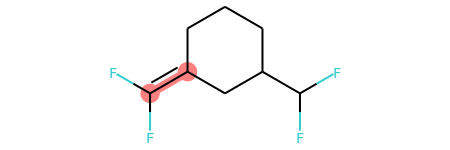

In [8]:
retro.frp_depolymerize(Chem.MolFromSmiles(inds[0]))

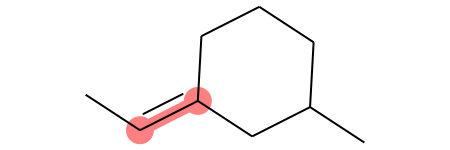

In [9]:
retro.frp_depolymerize(Chem.MolFromSmiles(inds[1]))

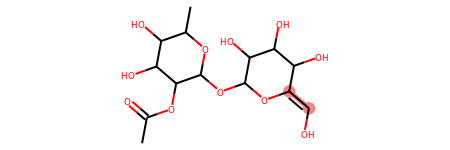

In [10]:
retro.frp_depolymerize(Chem.MolFromSmiles(inds[2]))

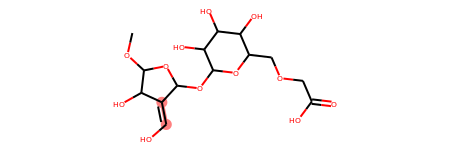

In [11]:
retro.frp_depolymerize(Chem.MolFromSmiles(inds[3]))

# Run frp_possible on G2G all paper results

In [35]:
df = ru.pd_load('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/first_cib_model/results_List/uniqueCanPolyAndProps.csv')
df.head()

,smiles,tg,bg,cib
0,[*]C(C)CCCCCCCCC1C2CCC(C2)C1C1(CCCCCCCCCCC([*]...,315.868362,5.577356,2.921176
1,[*]C1CC(NC(=O)OC2CC3CCCC(C2)O3)CCC1CC1CCC(NC(=...,484.888270,5.491678,2.680727
2,[*]C(CC)CCCCCCCC1C2CCC(C2)C1C1C2CCC(C2)C1C([*]...,347.465907,6.147327,3.238905
3,[*]C1NC(C)CN(C(=O)C2CCCCC2C(=O)N2CC(C)N(C(=O)C...,446.112044,5.642420,2.740090
4,[*]C([*])OC(=O)C1(C)CC2CC1C1C(CCC3CCC4C3C3CC4C...,463.547114,4.624584,2.283929


In [36]:
df_med = df[(df['bg']>5.5)&(df['cib']>2.5)&(df['tg']>400)].drop_duplicates()
len(df_med)

16855

In [37]:
smiles_ls = df_med['smiles'].tolist()
len(smiles_ls)

16855

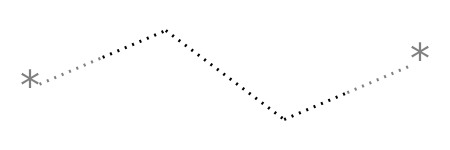

In [17]:
Chem.MolFromSmarts('[#0][CH2]C[#0]')

In [38]:
out = [x for x in smiles_ls if retro.frp_depolymerize(x) != None]
len(out)

28

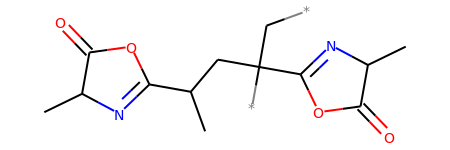

In [39]:
Chem.MolFromSmiles(out[0])

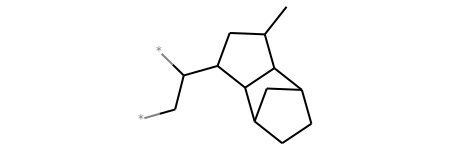

In [40]:
Chem.MolFromSmiles(out[1])

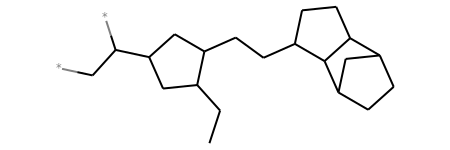

In [41]:
Chem.MolFromSmiles(out[2])

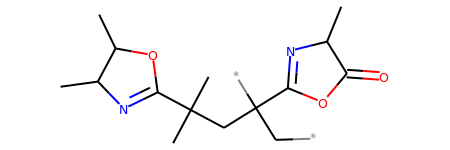

In [42]:
Chem.MolFromSmiles(out[4])

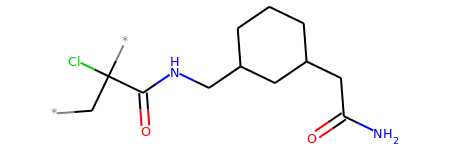

In [43]:
Chem.MolFromSmiles(out[5])

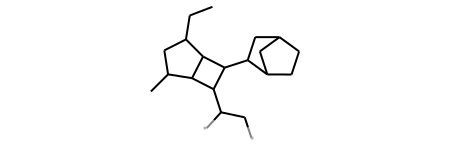

In [44]:
Chem.MolFromSmiles(out[6])

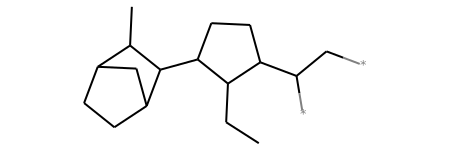

In [45]:
Chem.MolFromSmiles(out[7])

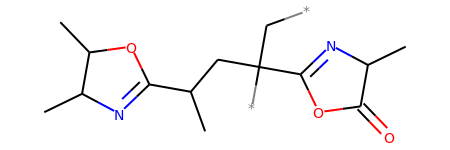

In [46]:
Chem.MolFromSmiles(out[8])

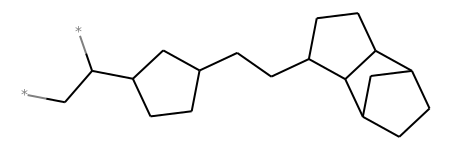

In [47]:
Chem.MolFromSmiles(out[9])

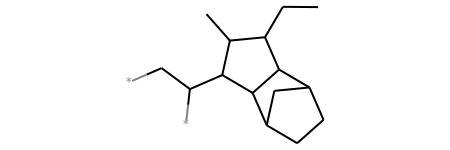

In [48]:
Chem.MolFromSmiles(out[12])

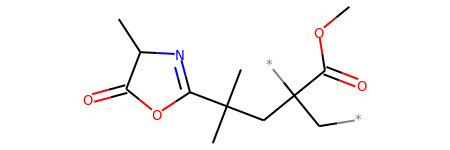

In [49]:
Chem.MolFromSmiles(out[14])

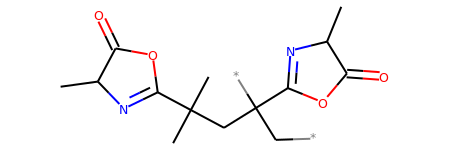

In [31]:
Chem.MolFromSmiles(out[18])

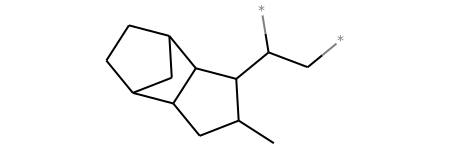

In [33]:
Chem.MolFromSmiles(out[20])

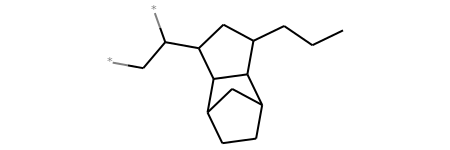

In [34]:
Chem.MolFromSmiles(out[21])

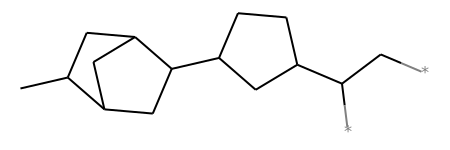

In [35]:
Chem.MolFromSmiles(out[22])

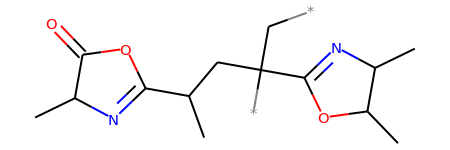

In [36]:
Chem.MolFromSmiles(out[23])

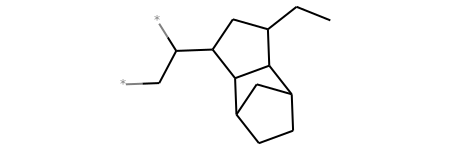

In [38]:
Chem.MolFromSmiles(out[25])

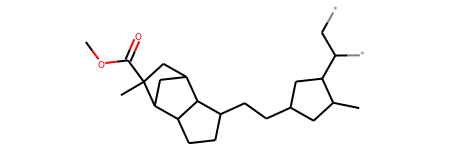

In [39]:
Chem.MolFromSmiles(out[26])

In [23]:
df[df['smiles']==out[1]]

,smiles,tg,bg,cib
2138,[*]CC([*])(CC(C)C1=NC(C)C(=O)O1)C1=NC(C)C(=O)O1,423.798977,5.899242,2.919123
8601,[*]CC([*])(CC(C)C1=NC(C)C(=O)O1)C1=NC(C)C(=O)O1,423.798977,5.899242,2.919123
28752,[*]CC([*])(CC(C)C1=NC(C)C(=O)O1)C1=NC(C)C(=O)O1,423.798977,5.899242,2.919123
39898,[*]CC([*])(CC(C)C1=NC(C)C(=O)O1)C1=NC(C)C(=O)O1,423.798977,5.899242,2.919123


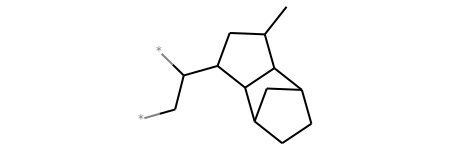

In [24]:
Chem.MolFromSmiles(out[2])

In [25]:
df[df['smiles']==out[2]]

,smiles,tg,bg,cib
2409,[*]CC([*])C1CC(C)C2C3CCC(C3)C12,472.222304,5.747219,3.458461
3762,[*]CC([*])C1CC(C)C2C3CCC(C3)C12,472.222304,5.747219,3.458461
12180,[*]CC([*])C1CC(C)C2C3CCC(C3)C12,472.222304,5.747219,3.458461
13652,[*]CC([*])C1CC(C)C2C3CCC(C3)C12,472.222304,5.747219,3.458461
33830,[*]CC([*])C1CC(C)C2C3CCC(C3)C12,472.222304,5.747219,3.458461
51575,[*]CC([*])C1CC(C)C2C3CCC(C3)C12,472.222304,5.747219,3.458461


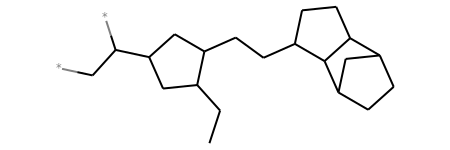

In [29]:
Chem.MolFromSmiles(out[5])

In [33]:
df[df['smiles']==out[5]]

,smiles,tg,bg,cib
5635,[*]CC([*])C1CC(CC)C(CCC2CCC3C4CCC(C4)C23)C1,421.030279,5.524643,3.154625
44344,[*]CC([*])C1CC(CC)C(CCC2CCC3C4CCC(C4)C23)C1,421.030279,5.524643,3.154625


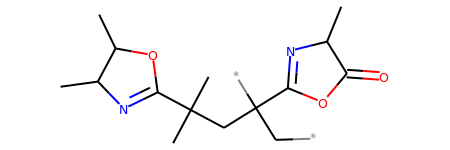

In [38]:
Chem.MolFromSmiles(out[10])

In [39]:
df[df['smiles']==out[10]]

,smiles,tg,bg,cib
11600,[*]CC([*])(CC(C)(C)C1=NC(C)C(C)O1)C1=NC(C)C(=O)O1,418.250602,6.074991,3.362081


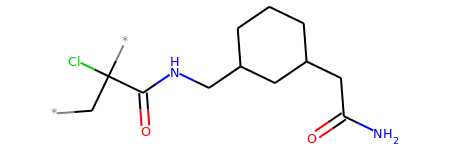

In [40]:
Chem.MolFromSmiles(out[11])

In [41]:
df[df['smiles']==out[11]]

,smiles,tg,bg,cib
11792,[*]CC([*])(Cl)C(=O)NCC1CCCC(CC(N)=O)C1,443.209028,5.569672,2.862899


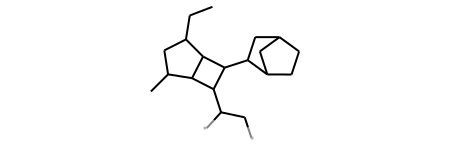

In [42]:
Chem.MolFromSmiles(out[12])

In [43]:
df[df['smiles']==out[12]]

,smiles,tg,bg,cib
12148,[*]CC([*])C1C2C(C)CC(CC)C2C1C1CC2CCC1C2,416.1335,5.76206,3.213548


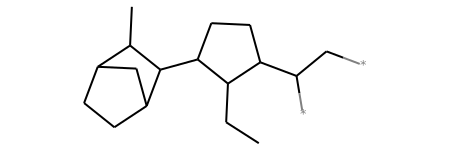

In [46]:
Chem.MolFromSmiles(out[14])

In [48]:
df[df['smiles']==out[14]]

,smiles,tg,bg,cib
12772,[*]CC([*])C1CCC(C2C3CCC(C3)C2C)C1CC,439.726743,5.724267,3.321802


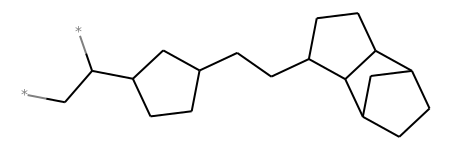

In [51]:
Chem.MolFromSmiles(out[17])

In [52]:
df[df['smiles']==out[17]]

,smiles,tg,bg,cib
14194,[*]CC([*])C1CCC(CCC2CCC3C4CCC(C4)C23)C1,429.882395,5.537663,3.127676
24447,[*]CC([*])C1CCC(CCC2CCC3C4CCC(C4)C23)C1,429.882395,5.537663,3.127676
51545,[*]CC([*])C1CCC(CCC2CCC3C4CCC(C4)C23)C1,429.882395,5.537663,3.127676


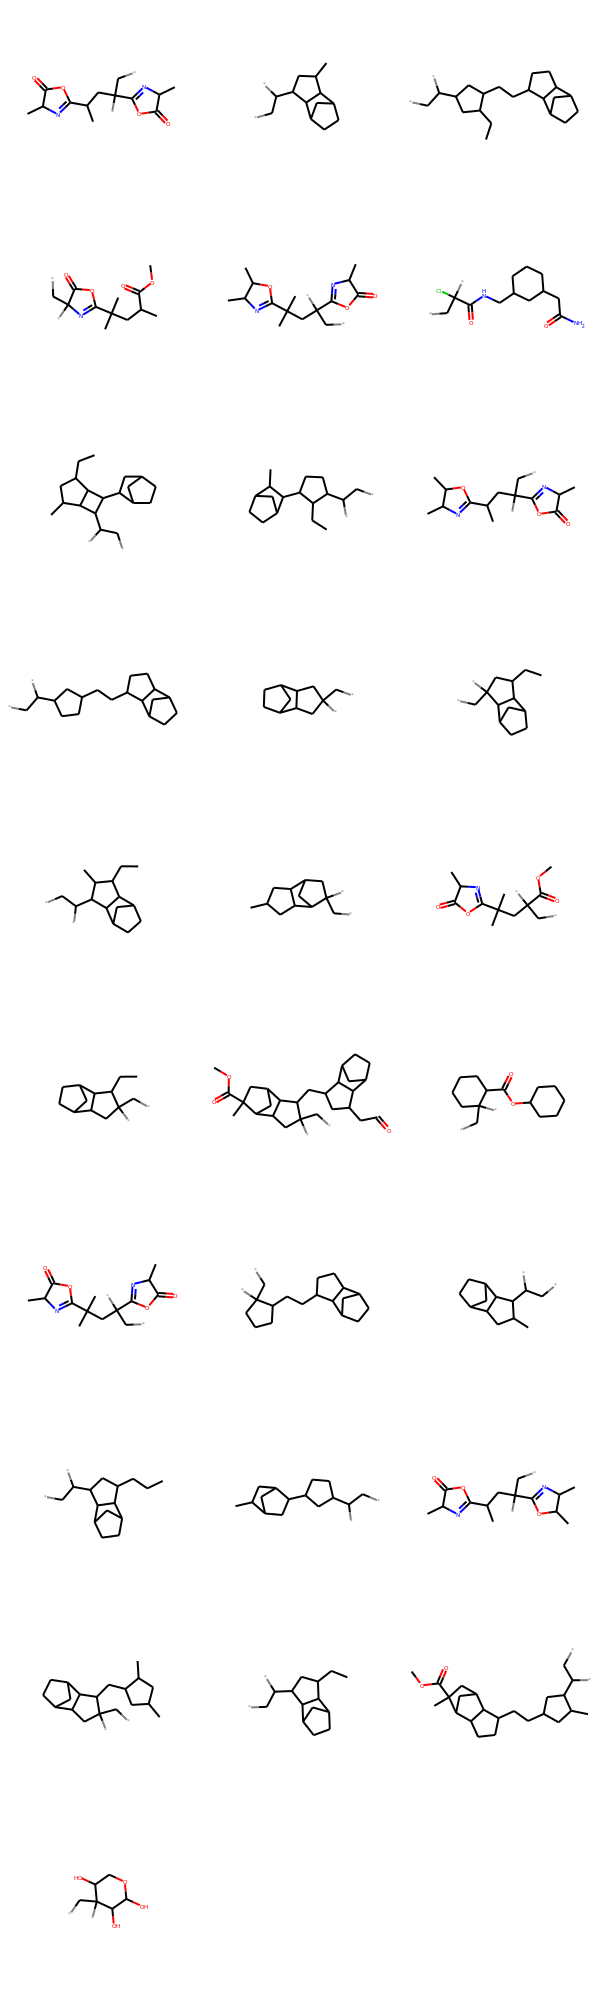

In [59]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in out])

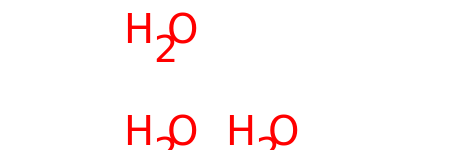

In [62]:
ru.LinearPol(out[27]).SideChainMol()

# Check [*]CO[*] polymers

# Check [*]CCCC[*] polymers

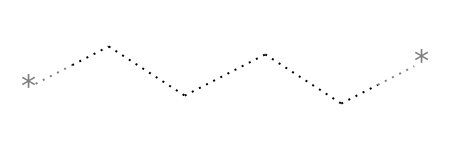

In [38]:
Chem.MolFromSmarts('[#0]C[CH2]C[CH2][#0]')

In [39]:
smiles_ls = success['SMILES'].tolist()
inds = [x for x in smiles_ls if Chem.MolFromSmiles(x).HasSubstructMatch(Chem.MolFromSmarts('[#0]C[CH2]C[CH2][#0]'))]
inds

['[*]CC1CC2C3CCC(C3)C2([*])C1',
 '[*]CC1CC2C(CC3CCC4C5CCC(C5)C34)NCC2([*])C1',
 '[*]CC1CC2C3CC(CC3C)C2([*])C1',
 '[*]CC1CC2([*])CC1C1CCC(CCC3CC(CC)C4C5CCC(C5)C34)C12',
 '[*]CC1CC2([*])CC1C1CCC(CCC3CC(CC)C4C5CC(C)C(C5)C34)C12',
 '[*]CC1CC([*])(CC)C2C3CCC(C3)C12',
 '[*]CC1CC2([*])CC1C1CCC(CCC3CCC(CC)C3)C12']

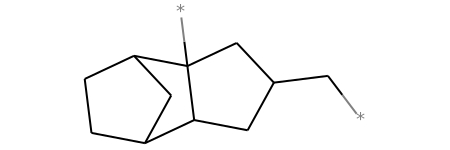

In [40]:
Chem.MolFromSmiles(inds[0])

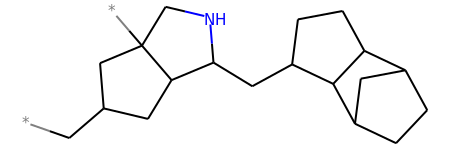

In [41]:
Chem.MolFromSmiles(inds[1])

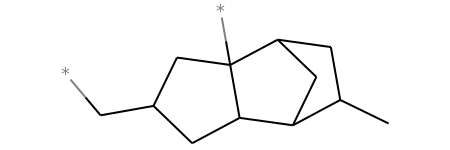

In [42]:
Chem.MolFromSmiles(inds[2])

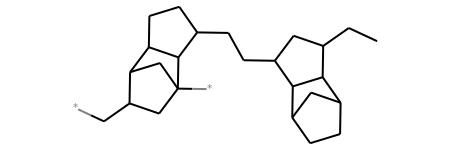

In [43]:
Chem.MolFromSmiles(inds[3])

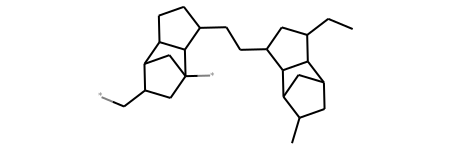

In [44]:
Chem.MolFromSmiles(inds[4])

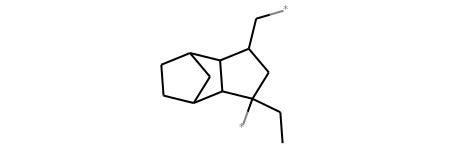

In [45]:
Chem.MolFromSmiles(inds[5])

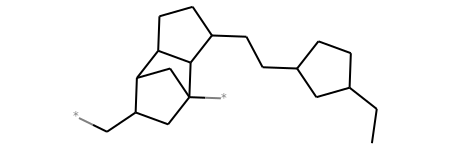

In [46]:
Chem.MolFromSmiles(inds[6])

# Look for target polymers with [*]CC[*]

In [4]:
df = ru.pd_load('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/../property_data/property_data.csv')
df.head()

,Bandgap,CIB,Tg,smiles
0,6.828510,3.542109,239.302690,[*]C[*]
1,4.977452,3.494155,293.363913,[*]CC([*])C
2,6.673815,3.534393,255.176840,[*]CC([*])CC
3,6.633060,3.546230,245.806539,[*]CC([*])CCC
4,6.336481,3.492962,305.693967,[*]CC([*])C(C)C


In [5]:
df_med = df[(df['Bandgap']>5.5)&(df['CIB']>3)&(df['Tg']>400)]
len(df_med)

61

In [56]:
inds = [ind for ind,x in enumerate(df_med['smiles'].tolist()) if Chem.MolFromSmiles(x).HasSubstructMatch(Chem.MolFromSmiles('*CC*'))]
inds

[0, 1, 3, 17, 18, 19, 21, 22, 23, 24, 30, 32, 33, 55, 59, 60]

In [57]:
len(inds)

16

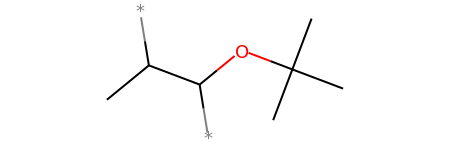

In [59]:
Chem.MolFromSmiles(df_med['smiles'].tolist()[inds[0]])

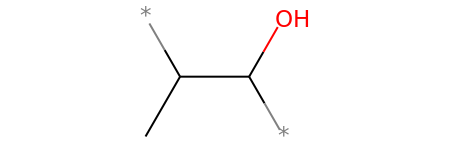

In [60]:
Chem.MolFromSmiles(df_med['smiles'].tolist()[inds[1]])

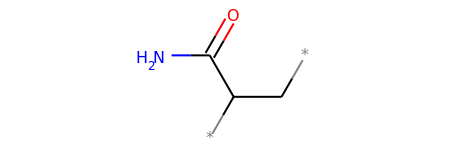

In [61]:
Chem.MolFromSmiles(df_med['smiles'].tolist()[inds[2]])

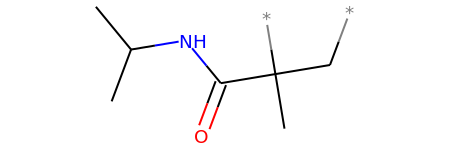

In [62]:
Chem.MolFromSmiles(df_med['smiles'].tolist()[inds[12]])

# dap on all polymers

In [ ]:
smiles = []
with open('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/first_cib_model/results_List/resultsList.txt','r') as f:
    for line in f:
        smiles.append(line.strip())
smiles[0:5]

In [ ]:
len(smiles)

In [ ]:
inds = [x for x in smiles if retro.dap_depolymerize(x) != None]
inds

In [ ]:
len(inds)

In [ ]:
retro.dap_depolymerize(inds[0])

In [ ]:
retro.dap_depolymerize(inds[1])

In [ ]:
retro.dap_depolymerize(inds[2])

In [ ]:
retro.dap_depolymerize(inds[3])

# Acidify chain...doesn't work

In [ ]:
patt1 = Chem.MolFromSmarts('[CH1,CH2,CH3]=[CH1,CH2,CH3]')
patt1

In [ ]:
patt2 = Chem.MolFromSmarts('[cH1,cH2,cH3][cH1,cH2,cH3]')
patt2

In [ ]:
Chem.MolFromSmiles('C=C').HasSubstructMatch(patt) #should be true

In [ ]:
m = Chem.MolFromSmiles('C(Cl)(Cl)=C')
m.HasSubstructMatch(patt) #should be false

In [ ]:
m

In [ ]:
m = Chem.MolFromSmiles('c1ccccc1')
m.HasSubstructMatch(patt) #should be False

In [ ]:
m = Chem.MolFromSmiles('c1ccccc1')
m.HasSubstructMatch(patt2) #should be True

In [ ]:
m.GetSubstructMatches(patt2)

In [ ]:
ru.mol_with_atom_index(m)

In [ ]:
matches = m.GetSubstructMatches(patt2)
matches

In [ ]:
em = Chem.EditableMol(m)

In [ ]:
o1=em.AddAtom(Chem.AtomFromSmiles('O'))
o2=em.AddAtom(Chem.AtomFromSmiles('O'))
c1 = em.AddAtom(Chem.AtomFromSmiles('C'))
c2 = em.AddAtom(Chem.AtomFromSmiles('C'))

In [ ]:
# #bind new atoms
# em.AddBond(o1,c1,Chem.BondType.SINGLE)
# em.AddBond(o2,c1,Chem.BondType.DOUBLE)
# em.AddBond(c2,c1,Chem.BondType.SINGLE)

# # #switch double/aromatic bond to single
# em.RemoveBond(matches[2][0],matches[2][1])
# em.AddBond(matches[2][0],matches[2][1],Chem.BondType.SINGLE)

#bind to original
em.AddBond(matches[2][0],o1,Chem.BondType.SINGLE)
em.GetMol()

# Make hclify

In [ ]:
patt = Chem.MolFromSmarts('[CH2,CH1]=C')
patt

In [ ]:
m = Chem.MolFromSmiles('*/C=C/*')
m

In [ ]:
ru.mol_with_atom_index(m)

In [ ]:
match=m.GetSubstructMatches(patt)
match

In [ ]:
em = Chem.EditableMol(m)

In [ ]:
Cl=em.AddAtom(Chem.AtomFromSmiles('Cl'))

In [ ]:
em.RemoveBond(match[0][0],match[0][1])
em.AddBond(match[0][0],match[0][1],Chem.BondType.SINGLE)
em.AddBond(match[0][0],Cl,Chem.BondType.SINGLE)
em.GetMol()

In [ ]:
m2 = Chem.MolFromSmiles('*/C(C#N)=C/C1C=CC(*)CC1')
m2

In [ ]:
out = retro.hclify(m2)

In [ ]:
out

In [ ]:
out[0]

In [ ]:
out[1]

In [ ]:
out[2]

# ppf poly(carboxylic acid) + carbodiimide
ppf = post-polymerization functionalization

In [ ]:
m=Chem.MolFromSmiles('*CC(C)*')
m

In [ ]:
lp = ru.LinearPol(m)

In [ ]:
lp.SideChainMol()

In [ ]:
Chem.MolFromSmarts('C(=O)[NH][R1]')

In [ ]:
from rdkit.Chem import AllChem
rxn = AllChem.ReactionFromSmarts('C(=O)[NH]>>C(=O)[OH]')
rxn3 = AllChem.ReactionFromSmarts('C(=O)[NH]>>C(=O)[OH]')

In [ ]:
rxn2 = AllChem.ChemicalReaction()
for i in range(rxn.GetNumReactantTemplates()):
    rxn2.AddProductTemplate(rxn.GetReactantTemplate(i))
for i in range(rxn.GetNumProductTemplates()):
    rxn2.AddReactantTemplate(rxn.GetProductTemplate(i))
rxn2.Initialize()

In [ ]:
m2 = Chem.MolFromSmiles('CCCC(=O)NCCCCC')
m2

In [ ]:
rxn.RunReactants([m2])[0][0]

In [ ]:
mod_mol = Chem.ReplaceSubstructs(m2, 
                                 Chem.MolFromSmarts('C(=O)[NH]'), 
                                 Chem.MolFromSmiles('C(=O)[OH]'),
                                 replaceAll=True)
mod_mol

In [ ]:
mod_mol[0]

In [ ]:
def isHydrocarbon(smiles):
    if type(smiles) != str:
        smiles = Chem.MolToSmiles(smiles)
    smiles=smiles.lower()
    filtered = [c.lower() for c in smiles if c.isalpha()]
    if smiles.count('c') == len(filtered):
        return True
    else:
        return False

In [ ]:
isHydrocarbon(Chem.MolFromSmiles('CC')) #should be True

In [ ]:
isHydrocarbon(Chem.MolFromSmiles('COC')) #should be False

In [ ]:
mod_mol_str = Chem.MolToSmiles(mod_mol[0])
mod_mol_str

In [ ]:
ls=mod_mol_str.split('.')
ls

In [ ]:
non_hc = []
for s in ls:
    if not isHydrocarbon(s):
        non_hc.append(s)
print(non_hc)
if len(non_hc) == 1:
    Chem.MolFromSmiles(non_hc[0])

In [ ]:
Chem.MolFromSmiles(non_hc[0])

In [ ]:
m3 = Chem.MolFromSmiles('*C(COCC(*)C(=O)NCC)C(=O)NC')
m3

In [ ]:
retro.ppf_poly_carboxylic_acid_plus_carbodiimide(m3)

In [ ]:
m4 = Chem.MolFromSmiles('*C(CCC(*)C(=O)NCC)C(=O)NO')
m4

In [ ]:
retro.ppf_poly_carboxylic_acid_plus_carbodiimide(m4) #should return None

In [ ]:
inds = [x for x in smiles if retro.ppf_poly_carboxylic_acid_plus_carbodiimide(x) != None]
inds

In [ ]:
len(inds)

# ppf thiol-ene

In [ ]:
R_groups = ['COC(C)=O','CC(C)(C)OC(=O)NCC(=O)O','Cc1ccccc1','C(N)C(=O)O','CCN(C)CC','C(O)CO','CC(F)(F)C(F)(F)F']

In [ ]:
Chem.MolFromSmiles('CS%s'%'COC(C)=O')

In [ ]:
# inds = [x for x in smiles if retro.dap_depolymerize(x) != None]
# inds
pol_matches = []
for x in smiles:
    lp = ru.LinearPol(x)
    try:
        scm=lp.SideChainMol()
        matches = []
        for r in R_groups:
            ss = Chem.MolFromSmiles('CS%s'%r)
            if scm.HasSubstructMatch(ss):
                pol_matches.append(x)
                break
    except:
        pass

In [ ]:
len(pol_matches)

# Make hydrogenate_chain

In [ ]:
m5 = Chem.MolFromSmiles('*CCCC1(C)CCC1*')
m5

In [ ]:
ru.mol_with_atom_index(m5)

In [ ]:
patt = Chem.MolFromSmiles('CC')

In [ ]:
m5.HasSubstructMatch(patt)

In [ ]:
m5.GetSubstructMatches(patt)

In [ ]:
m5.GetBonds()

In [ ]:
em = Chem.EditableMol(m5)

In [ ]:
em.RemoveBond(0,1)
em.AddBond(0,1,Chem.BondType.DOUBLE)

In [ ]:
em.GetMol()

In [ ]:
Chem.SanitizeMol(em.GetMol())

# Test hydrogenate_chain

In [ ]:
m5 = Chem.MolFromSmiles('*CCCC1(C)CCC1*')
m5

In [ ]:
new = hydrogenate_chain(m5)

In [ ]:
new[0]

In [ ]:
new[1]

In [ ]:
new[2]

In [ ]:
new[3]

In [ ]:
new[4]

# Make get connector_inds

In [ ]:
m5 = Chem.MolFromSmiles('*CCCC1(C)CCC1*')
m5

ru.mol_with_atom_index(m5)

In [ ]:
a=m5.GetAtoms()

In [ ]:
b=a[4]

In [ ]:
c=b.GetNeighbors()[0]

In [ ]:
c.GetIdx()

# Test get_connector_inds

In [ ]:
ru.get_connector_inds(m5)

# Make periodic_mol

In [ ]:
m5 = Chem.MolFromSmiles('*CCCC1(C)CCC1*')
m5

ru.mol_with_atom_index(m5)

In [ ]:
p5=ru.LinearPol(m5)

In [ ]:
p5.connector_inds

In [ ]:
p5.star_inds

In [ ]:
em = Chem.EditableMol(m5)
em

In [ ]:
em.AddBond(p5.connector_inds[0],p5.connector_inds[1],Chem.BondType.SINGLE)
em.RemoveAtom(p5.star_inds[0])
em.RemoveAtom(p5.star_inds[1] - 1)

In [ ]:
em.GetMol()

# Test PeriodicMol

In [ ]:
ru.LinearPol(m6).PeriodicMol()

# Make sg_possible

In [ ]:
m6 = Chem.MolFromSmiles('*Oc2ccc(C(C)(C)c1ccc(OC(*)=O)cc1)cc2')

In [ ]:
def sg_possible(mol):
    possible_patt_smiles = ['CO']
    has_patt = []
    lp = ru.LinearPol(mol)
    pm = lp.PeriodicMol()
    for s in possible_patt_smiles:
        if len(pm.GetSubstructMatches(Chem.MolFromSmiles(s))) > 1:
            has_patt.append(s)
    if len(has_patt) > 0:
        return (True,has_patt)
    else:
        return (False,has_patt)

In [ ]:
sg_possible(m6) #should be True

In [ ]:
sg_possible(m5) #should be False

# Make depolymerize

In [ ]:
patt = 'CO'

In [ ]:
lp = ru.LinearPol(m6)
pm = lp.PeriodicMol()

In [ ]:
pm

In [ ]:
pm.GetSubstructMatches(Chem.MolFromSmiles(patt))

In [ ]:
ru.mol_with_atom_index(pm)

In [ ]:
em = Chem.EditableMol(pm)

In [ ]:
em.RemoveBond(13,0)
em.RemoveBond(13,12)
em.AddAtom(Chem.AtomFromSmiles('[Cl]'))
em.AddAtom(Chem.AtomFromSmiles('[Cl]'))
em.AddBond(13,19,Chem.BondType.SINGLE)
em.AddBond(13,20,Chem.BondType.SINGLE)
m=em.GetMol()
Chem.SanitizeMol(m)

# em = Chem.EditableMol(m)
# em.AddAtom(Chem.AtomFromSmiles('[Cl]'))
# em.AddAtom(Chem.AtomFromSmiles('[Cl]'))
# em.AddBond(13,19,Chem.BondType.SINGLE)
# em.AddBond(13,20,Chem.BondType.SINGLE)
# m=em.GetMol()
# Chem.SanitizeMol(m)
m

In [ ]:
for atom in m.GetAtoms():
    atom.SetAtomMapNum(0)
m

# Test depolymerize

In [ ]:
m6 = Chem.MolFromSmiles('*Oc2ccc(C(C)(C)c1ccc(OC(*)=O)cc1)cc2')
patt = 'CO'

lp = ru.LinearPol(m6)
pm = lp.PeriodicMol()

In [ ]:
monomer_sets=retro.depolymerize(lp,patt)
monomer_sets

In [ ]:
a=monomer_sets[0]

In [ ]:
Chem.SanitizeMol(a)

In [ ]:
Chem.MolToSmiles(a)

In [ ]:
from IPython.display import SVG
SVG(ru.drawFromSmiles('CC(C)(c1ccc(Cl)cc1)c1ccc(Cl)cc1.O=C(O)O'))

# Test depolymerize on data set

In [ ]:
success = ru.pd_load('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/first_cib_model/new_polymers_12_43PM_on_June_23_2020_sortedObjective.csv')
success.head()

In [ ]:
len(success)

In [ ]:
def test(s):
    return retro.depolymerize(ru.LinearPol(s),'CO')

In [ ]:
smiles_ls = success['SMILES'].tolist()
inds = [x for x in smiles_ls if retro.sg_possible(x)[0]]
inds

In [ ]:
inds[0], len(inds)

In [ ]:
sets = [(s,test(s)) for s in inds if s != None]

In [ ]:
success = [x for x in sets if x[1] != []]
len(success)

In [ ]:
success[24][1][0]

In [ ]:
Chem.MolFromSmiles(success[3][0])

In [ ]:
success[0][1]

In [ ]:
success[220][0]

In [ ]:
p6 = ru.LinearPol(m6)
Chem.GetShortestPath(m6,p6.star_inds[0],p6.star_inds[1])

In [ ]:
ru.mol_with_atom_index(m6)

# Make symmetry...doesn't work

In [ ]:
x=Chem.MolFromSmiles('c1cc(*)ccc1*')

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdmolfiles
import time

def is_symmetric(mol):
    if type(mol) == str:
        mol = Chem.MolFromSmiles(mol)    
    z=list(rdmolfiles.CanonicalRankAtoms(mol, breakTies=False))
    print(z)
    return len(z) != len(set(z))

In [ ]:
is_symmetric(x) #should be True

In [ ]:
is_symmetric('CO') #should be False

In [ ]:
is_symmetric('CC') #should be True

In [ ]:
is_symmetric('C1NCN1')

In [ ]:
Chem.MolToSmiles(m)

In [ ]:
is_symmetric('O=C(Cl)Cl')

In [ ]:
is_symmetric('CC(C)(c1ccc(O)cc1)c1ccc(O)cc1')

In [ ]:
import itertools

In [ ]:
list(itertools.combinations([0,1,2], 2))

Check for Rings of type 'CNC(=O)' and 'COC(=O)'

In [ ]:
success = ru.pd_load('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/first_cib_model/new_polymers_12_43PM_on_June_23_2020_sortedObjective.csv')
success.head()

len(success)

def test(s):
    return retro.depolymerize(ru.LinearPol(s),'CO')

smiles_ls = success['SMILES'].tolist()

In [ ]:
smiles_ls[0]

In [ ]:
patt1=Chem.MolFromSmiles('CNC(=O)')
patt2=Chem.MolFromSmiles('COC(=O)')

In [ ]:
Chem.MolFromSmiles(smiles_ls[0])

In [ ]:
ru.LinearPol(smiles_ls[0]).AlphaMol()

In [ ]:
success = []
for i,x in enumerate(smiles_ls):
    try:
        y=ru.LinearPol(x).AlphaMol()
        if len(y.GetSubstructMatches(patt1))==1 or len(y.GetSubstructMatches(patt2))==1:
            success.append(x)
    except:
        pass

In [ ]:
len(success)

In [ ]:
Chem.MolFromSmiles(success[0])

In [ ]:
Chem.MolFromSmiles(success[423])

# Test alpha_chain

In [ ]:
m8 = Chem.MolFromSmiles('[*]C1OC(C2CC(C)CC(CC(=O)NCC3CCCC(CC(N)=O)C3[*])C2)=NC1C')
p8 = ru.LinearPol(m8)

In [ ]:
p8.main_chain_atoms

In [ ]:
m8

In [ ]:
p8.AlphaMol()

# Check for MURI fragment

In [ ]:
all_polymers = []
with open('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/first_cib_model/results_List/resultsList.txt','r') as f:
    for line in f:
        all_polymers.append(line.strip())

In [ ]:
len(all_polymers)

In [ ]:
ru.LinearPol(all_polymers[100]).mol

In [ ]:
Chem.MolFromSmiles('C(C=O)')

In [ ]:
success = []
patt = Chem.MolFromSmiles('C(C=O)')
for i,x in enumerate(all_polymers[0:800]):
    try:
        y=ru.LinearPol(x).PeriodicMol()
        if y.HasSubstructMatch(patt):
            success.append(x)
    except:
        pass

In [ ]:
len(success)

In [ ]:
Chem.MolFromSmiles(success[12])

In [ ]:
Chem.MolFromSmiles(success[3])

In [ ]:
Chem.MolFromSmiles(success[4])

In [ ]:
Chem.MolFromSmiles(success[5])

In [ ]:
Chem.MolFromSmiles(success[6])

In [ ]:
Chem.MolFromSmiles(success[7])

In [ ]:
Chem.MolFromSmiles(success[8])

In [ ]:
Chem.MolFromSmiles(success[2])

# Try ADMET depolymerize

In [ ]:
m = Chem.MolFromSmiles('*CCC*')
m

In [ ]:
retro.hydrogenate_chain(m)[1]

In [ ]:
a=ru.LinearPol(retro.hydrogenate_chain(m)[0])

In [ ]:
a = retro.admet_depolymerize(ru.LinearPol(retro.hydrogenate_chain(m)[0]))
a

In [ ]:
a.

In [ ]:
ru.is_symmetric_chem(a)

In [ ]:
success = ru.pd_load('/data/rgur/g2g/paper_1/cib_tg_eg/cutoff-.1/first_cib_model/new_polymers_12_43PM_on_June_23_2020_sortedObjective.csv')
success.head()

len(success)

def test(s):
    return retro.depolymerize(ru.LinearPol(s),'CO')

smiles_ls = success['SMILES'].tolist()

In [ ]:
success = []
for i,x in enumerate(smiles_ls):
    try:
        monomer = retro.admet_depolymerize(ru.LinearPol(retro.hydrogenate_chain(x)[0]))
        if ru.is_symmetric_chem(monomer):
            success.append((Chem.MolFromSmiles(x),monomer))
    except:
        pass

In [ ]:
rm_none = [x for x in success if x[1] != None]

In [ ]:
len(success)

In [ ]:
len(rm_none)

In [ ]:
rm_none[0][0]

In [ ]:
rm_none[0][1]

In [ ]:
rm_none[1][0]

In [ ]:
rm_none[1][1]

In [ ]:
rm_none[2][0]

In [ ]:
rm_none[2][1]

# Thiol + electrophile
The theory is that the more e- deficient the C=C (i.e. more +ve the charge on the carbons), the higher the rate constant

In [ ]:
m2 = Chem.MolFromSmiles('Cn1c(=O)ccc1=O')
m2

In [ ]:
ru.mol_with_atom_index(m2)

In [ ]:
m2.GetAtoms()[4].GetProp('_GasteigerCharge') #rate constant = 8,000

In [ ]:
m3 = Chem.MolFromSmiles('COC(=O)C1=C(C(=O)OC)C2(C)C=CC1(C)O2')
m3

In [ ]:
ru.mol_with_atom_index(m3)

In [ ]:
ru.mol_with_partial_charge(m3)

In [ ]:
m3.GetAtoms()[4].GetProp('_GasteigerCharge') #rate constant = 30,000

In [ ]:
m3.GetAtoms()[5].GetProp('_GasteigerCharge') #rate constant = 30,000

In [ ]:
m3.GetAtoms()[12].GetProp('_GasteigerCharge') #rate constant = 30,000

In [ ]:
m3.GetAtoms()[13].GetProp('_GasteigerCharge') #rate constant = 30,000

In [ ]:
m4 = Chem.MolFromSmiles('C=C(C)')
m4

In [ ]:
ru.mol_with_atom_index(m4)

In [ ]:
ru.mol_with_partial_charge(m4)

In [ ]:
m3.GetAtoms()[0].GetProp('_GasteigerCharge')

In [ ]:
m3.GetAtoms()[1].GetProp('_GasteigerCharge')